# Cross Domain Normalization

In this notebook we test different models with CDN (Cross Domain Nromalization). We'll see that CDN neutralizes the CDS affect and regularizes the model. As a result we outperform state-of-the-art results while significantly speeding up the training time. The models outputs can be found in <font color='red'>./logs/CDN</font> (note that the update rates in the logs are scaled by 100)

In [1]:
import numpy as np
import tensorflow as tf
import json
from datetime import datetime
import os
import sys
sys.path.append('../')
sys.path.append('../models/')
import retriever
from stats import stats
from tabulate import tabulate
from runCDN import RunModel as Model
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
trainset_file = '../data/training/train_data.bin'
testset_file = '../data/training/test_data.bin'
vocab_file =  '../data/metadata/w2v_vocab.json'
params_dir_tmp = '../data/training/models/CDN/'

<h3>Each entry in this list has the following structure:</h3>
<ul>
<li>entry[0]: query indexes </li>
<li>entry[1:n]: n-1 items where each item is [bounding box vector, bounding box spaital features]. Note that different entries might have different number of possible  bounding boxes (i.e. different n) </li>
<li>entry[n+1]: integer, entry[ 1 + entry[n+1]] is the true bbox </li>
</ul>

In [3]:
trainset = np.load(open(trainset_file, 'rb'))

# delete data points where the query length is zero
trainset = np.array([item for item in trainset if len(item[0])!=0])

testset = np.load(open(testset_file, 'rb'))

# delete data points where the query length is zero
testset = np.array([item for item in testset if len(item[0])!=0])

# loading vocabulary 
with open(vocab_file, 'r') as f:
    vocab = json.loads(f.read())
vocab['<unk>'] = len(vocab)

print("Number of words:", len(vocab))

Number of words: 8916


## CDN

<p>Here we can see the results while using SG with CDN. We used Random Search in order to find the best scaling factors with which we've scaled the LN layers outputs, the best results were achieved by setting the image and language scaling factor to 0.023 and 0.16 respectively. The graphs show a much more stable behavior and a significant reduction in overfit which leads to a better P@1 and a lower loss.</p>

<p> Furthermore, CDN accelerates the training process. Without CDN we've got P@1 of 0.66 after 98 epochs, this result was outperform at the first epoch by only adding CDN, which achieved 0.846 P@1. In addition, with CDN the model trains about 4.4 times faster than GroundeR and 3.7 times faster than SG+SBN. While it took 96 epochs to get to 0.819 P@1 with GroundeR (SG + BN layers over the image and language models), with CDN we got to 0.822 P@1 after only 22 epochs. For SG+SBN (Scaled Batch Normalization) we also got the best P@1 (0.831) after 96 epochs, while SG+CDN got to the same P@1 after only 26 epochs.</p>

In [3]:
params_dir = params_dir_tmp+'CDN'
tf.reset_default_graph()
m = Model(
    batch_size=200, 
    num_hidden=200,
    img_dims=trainset[0][1][0].shape[1], 
    bbox_dims=testset[0][1][1].shape[1], 
    lr=.05,
    vocab=vocab, 
    decay_steps=10000, 
    decay_rate=0.9, 
    Qscale=0.16,
    IMGscale=0.023,
    params_dir=params_dir)


print('params_dir:', params_dir)
print('num_hidden:', m.num_hidden)
print('learning rate:', m.lr)

tst, trn, imgMean_list, imgSTD_list, imgRange_list, qMean_list, qSTD_list, qRange_list, Gq, Gimg = m.train(
    trainset, testset, epochs_num=60)

print('\n'+'*'*100)
print('*'*100)
print('*'*100,'\n')



Train accuracy:0.920
Test accuracy:0.770
Train P@1:0.954
Test P@1:0.846
Train loss loss:0.475
Test loss loss:1.113


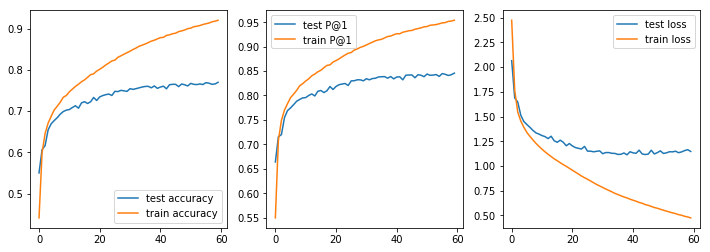

---------------------------------------------------------------------------------------------------- 



In [33]:
f = stats([tst], [trn], epochs=60, params=[200])

The source of the improvement can be seen by examining the update rates of the image and language models, CDN keeps the ratio between the update rates more stable. Note that unlike other experiments, where the loss increased once the ratio between update rates became too small, with CDN the loss decreases even when the ratio is one. 

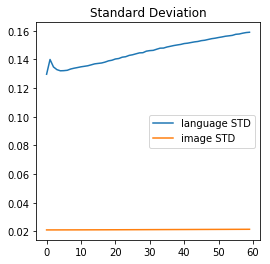

In [15]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [qSTD_list, imgSTD_list]
labels=[['language STD'], ['image STD']]
titles=["Standard Deviation"]
epochs=60

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(epochs), arr)
    P.legend([labels[k][0] for k in range(len(labels))], loc=0)
    P.set_title(title)
    P.plot()
plt.show()

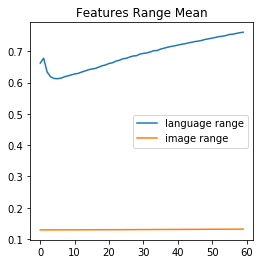

In [18]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [qRange_list, imgRange_list]
labels=[['language range'], ['image range']]
titles=["Features Range Mean"]
epochs=60

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(epochs), arr[:60])
    P.legend([labels[k][0] for k in range(len(labels))], loc=0)
    P.set_title(title)
    P.plot()
plt.show()

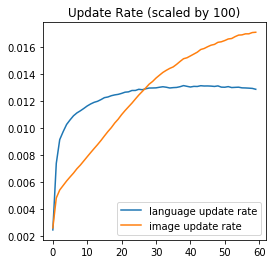

In [17]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [Gq, Gimg]
labels=[['language update rate'], ['image update rate']]
titles=["Update Rate (scaled by 100)"]
epochs=60

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(epochs), arr[:100])
    P.legend([labels[k][0] for k in range(len(labels))])
    P.set_title(title)
    P.plot()
plt.show()

## CDND 

Next we add dropout before and after the LSTM cell. CDN has the same effect as we saw in the previous experiment, however with dropout we get a better P@1. 

In [19]:
params_dir = params_dir_tmp+'CDND'
tf.reset_default_graph()
m = Model(
    batch_size=200, 
    num_hidden=200,
    img_dims=trainset[0][1][0].shape[1], 
    bbox_dims=testset[0][1][1].shape[1], 
    lr=.05,
    vocab=vocab, 
    decay_steps=10000, 
    decay_rate=0.9, 
    Qscale=0.16,
    IMGscale=0.023,
    params_dir=params_dir)


print('params_dir:', params_dir)
print('num_hidden:', m.num_hidden)
print('learning rate:', m.lr)

tst, trn, imgMean_list, imgSTD_list, imgRange_list, qMean_list, qSTD_list, qRange_list, Gq, Gimg = m.train(
    trainset, testset, epochs_num=100, dropout_in=0.5, dropout_out=0.5)

print('\n'+'*'*100)
print('*'*100)
print('*'*100,'\n')

Train accuracy:0.905
Test accuracy:0.779
Train IOU:0.942
Test IOU:0.853
Train loss loss:0.524
Test loss loss:1.038


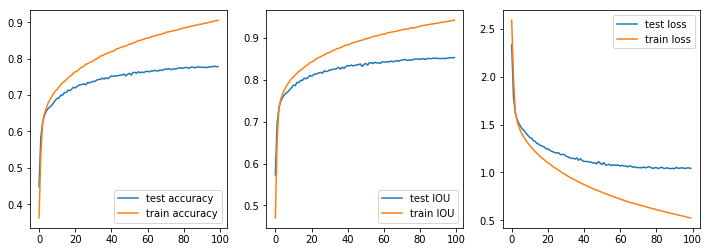

---------------------------------------------------------------------------------------------------- 



In [21]:
f = stats([tst], [trn], epochs=100, params=[200])

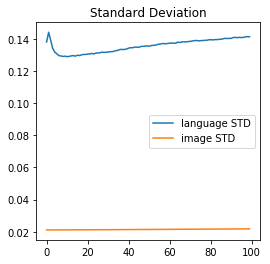

In [22]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [qSTD_list, imgSTD_list]
labels=[['language STD'], ['image STD']]
titles=["Standard Deviation"]
epochs=100

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(epochs), arr)
    P.legend([labels[k][0] for k in range(len(labels))], loc=0)
    P.set_title(title)
    P.plot()
plt.show()

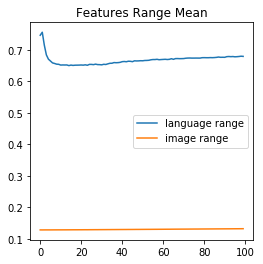

In [24]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [qRange_list, imgRange_list]
labels=[['language range'], ['image range']]
titles=["Features Range Mean"]
epochs=100

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(epochs), arr[:100])
    P.legend([labels[k][0] for k in range(len(labels))], loc=0)
    P.set_title(title)
    P.plot()
plt.show()

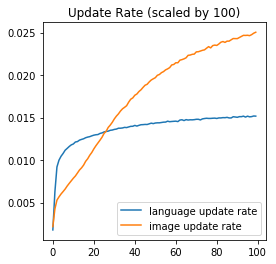

In [25]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [Gq, Gimg]
labels=[['language update rate'], ['image update rate']]
titles=["Update Rate (scaled by 100)"]
epochs=100

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(epochs), arr[:100])
    P.legend([labels[k][0] for k in range(len(labels))])
    P.set_title(title)
    P.plot()
plt.show()

<b>The following experiments test SG+CDN with bidirectional RNN, attention and both, in all experiments we used dropout only before the LSTM cell.</b>

<p>We see that adding bidirectional RNN and/or attention has only little effect on the models statistics. We get the best results with bidirectional RNN and with bidirectional RNN + attention, which yield similar results. Note that without CDN we saw that the attention mechanism was mainly used for overfitting, however, with CDN, attention improves the results in terms of both P@1 and regularization. </p>

## BiCDND

Bidirectional RNN + CDN + Dropout

In [4]:
params_dir = params_dir_tmp+'BiCDND'
tf.reset_default_graph()
m = Model(
    batch_size=200, 
    num_hidden=200,
    img_dims=trainset[0][1][0].shape[1], 
    bbox_dims=testset[0][1][1].shape[1], 
    lr=.05,
    vocab=vocab, 
    decay_steps=10000, 
    decay_rate=0.9, 
    useBidirectionalRnn=True,
    Qscale=0.16,
    IMGscale=0.023,
    params_dir=params_dir)


print('params_dir:', params_dir)
print('num_hidden:', m.num_hidden)
print('learning rate:', m.lr)

tst, trn, imgMean_list, imgSTD_list, imgRange_list, qMean_list, qSTD_list, qRange_list, Gq, Gimg = m.train(
    trainset, testset, epochs_num=100, dropout_in=0.5, dropout_out=1.)

print('\n'+'*'*100)
print('*'*100)
print('*'*100,'\n')

Train accuracy:0.929
Test accuracy:0.786
Train P@1:0.959
Test P@1:0.858
Train loss loss:0.416
Test loss loss:1.028


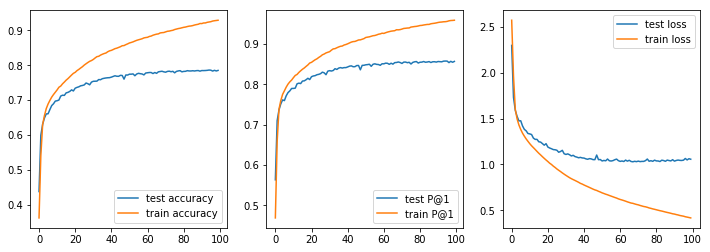

---------------------------------------------------------------------------------------------------- 



In [15]:
f = stats([tst], [trn], epochs=100, params=[200])

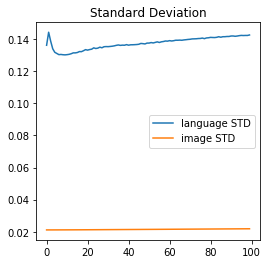

In [13]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [qSTD_list, imgSTD_list]
labels=[['language STD'], ['image STD']]
titles=["Standard Deviation"]
epochs=100

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(epochs), arr)
    P.legend([labels[k][0] for k in range(len(labels))], loc=0)
    P.set_title(title)
    P.plot()
plt.show()

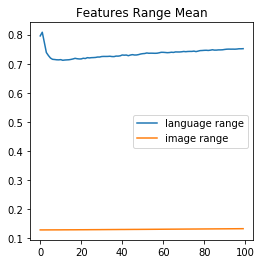

In [15]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [qRange_list, imgRange_list]
labels=[['language range'], ['image range']]
titles=["Features Range Mean"]
epochs=100

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(epochs), arr[:100])
    P.legend([labels[k][0] for k in range(len(labels))], loc=0)
    P.set_title(title)
    P.plot()
plt.show()

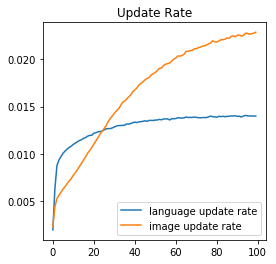

In [12]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [Gq, Gimg]
labels=[['language update rate'], ['image update rate']]
titles=["Update Rate"]
epochs=100

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(epochs), arr[:100])
    P.legend([labels[k][0] for k in range(len(labels))])
    P.set_title(title)
    P.plot()
plt.show()

## Attention CDND

prefix attention + CDN + Dropout

In [20]:
params_dir = params_dir_tmp+'attnCDN'
tf.reset_default_graph()
m = Model(
    batch_size=200, 
    num_hidden=200,
    img_dims=trainset[0][1][0].shape[1], 
    bbox_dims=testset[0][1][1].shape[1], 
    lr=.05,
    vocab=vocab, 
    decay_steps=10000, 
    decay_rate=0.9, 
    Qscale=0.16,
    use_wordAttn=True,
    IMGscale=0.023,
    params_dir=params_dir)


print('params_dir:', params_dir)
print('num_hidden:', m.num_hidden)
print('learning rate:', m.lr)

tst, trn, imgMean_list, imgSTD_list, imgRange_list, qMean_list, qSTD_list, qRange_list, Gq, Gimg = m.train(
    trainset, testset, epochs_num=100, dropout_in=0.5, dropout_out=1)

print('\n'+'*'*100)
print('*'*100)
print('*'*100,'\n')

Train accuracy:0.902
Test accuracy:0.777
Train P@1:0.940
Test P@1:0.853
Train loss loss:0.535
Test loss loss:1.046


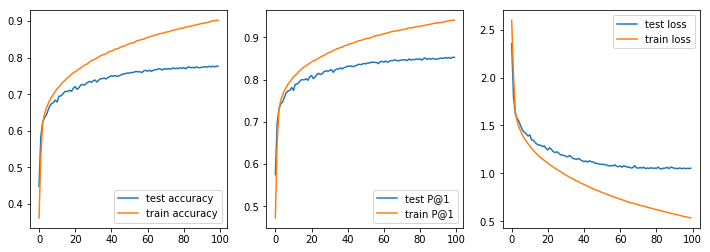

---------------------------------------------------------------------------------------------------- 



In [10]:
f = stats([tst], [trn], epochs=100, params=[200])

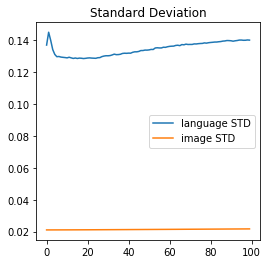

In [11]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [qSTD_list, imgSTD_list]
labels=[['language STD'], ['image STD']]
titles=["Standard Deviation"]
epochs=100

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(epochs), arr)
    P.legend([labels[k][0] for k in range(len(labels))], loc=0)
    P.set_title(title)
    P.plot()
plt.show()

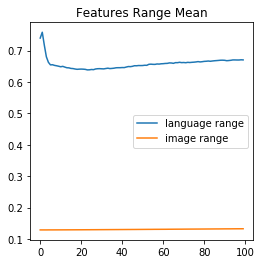

In [13]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [qRange_list, imgRange_list]
labels=[['language range'], ['image range']]
titles=["Features Range Mean"]
epochs=100

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(epochs), arr[:100])
    P.legend([labels[k][0] for k in range(len(labels))], loc=0)
    P.set_title(title)
    P.plot()
plt.show()

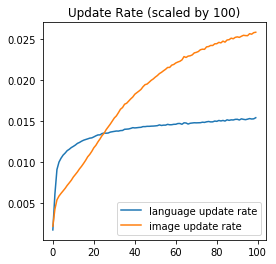

In [11]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [Gq, Gimg]
labels=[['language update rate'], ['image update rate']]
titles=["Update Rate (scaled by 100)"]
epochs=100

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(epochs), arr[:100])
    P.legend([labels[k][0] for k in range(len(labels))])
    P.set_title(title)
    P.plot()
plt.show()

## Attention and Bi CDND

Bidirectional RNN + prefix attention + CDN + Dropout

In [21]:
params_dir = params_dir_tmp+'attnBiCDN'
tf.reset_default_graph()
m = Model(
    batch_size=200, 
    num_hidden=200,
    img_dims=trainset[0][1][0].shape[1], 
    bbox_dims=testset[0][1][1].shape[1], 
    lr=.05,
    vocab=vocab, 
    decay_steps=10000, 
    decay_rate=0.9, 
    Qscale=0.16,
    use_wordAttn=True,
    useBidirectionalRnn=True,
    IMGscale=0.023,
    params_dir=params_dir)


print('params_dir:', params_dir)
print('num_hidden:', m.num_hidden)
print('learning rate:', m.lr)

tst, trn, imgMean_list, imgSTD_list, imgRange_list, qMean_list, qSTD_list, qRange_list, Gq, Gimg = m.train(
    trainset, testset, epochs_num=100, dropout_in=0.5, dropout_out=1)

print('\n'+'*'*100)
print('*'*100)
print('*'*100,'\n')

Train accuracy:0.927
Test accuracy:0.783
Train P@1:0.958
Test P@1:0.857
Train loss loss:0.426
Test loss loss:1.035


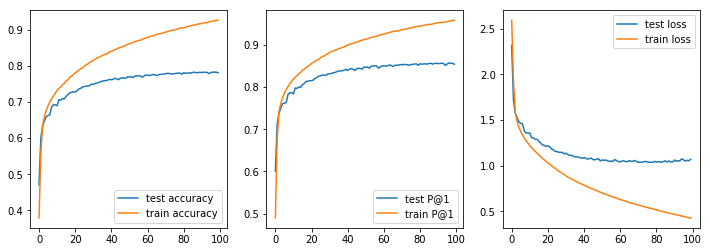

---------------------------------------------------------------------------------------------------- 



In [25]:
f = stats([tst], [trn], epochs=100, params=[1])

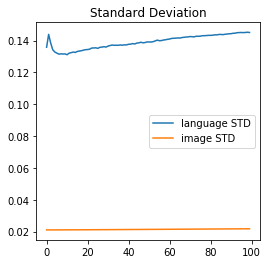

In [17]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [qSTD_list, imgSTD_list]
labels=[['language STD'], ['image STD']]
titles=["Standard Deviation"]
epochs=100

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(epochs), arr)
    P.legend([labels[k][0] for k in range(len(labels))], loc=0)
    P.set_title(title)
    P.plot()
plt.show()

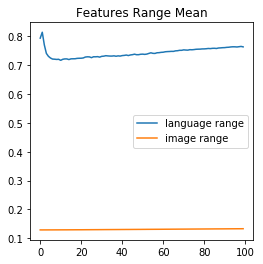

In [18]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [qRange_list, imgRange_list]
labels=[['language range'], ['image range']]
titles=["Features Range Mean"]
epochs=100

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(epochs), arr[:100])
    P.legend([labels[k][0] for k in range(len(labels))], loc=0)
    P.set_title(title)
    P.plot()
plt.show()

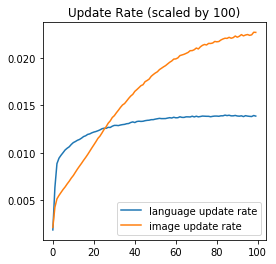

In [16]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [Gq, Gimg]
labels=[['language update rate'], ['image update rate']]
titles=["Update Rate (scaled by 100)"]
epochs=100

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(epochs), arr[:100])
    P.legend([labels[k][0] for k in range(len(labels))])
    P.set_title(title)
    P.plot()
plt.show()